# Data Augmentation using Keras API's

#Lets take horses and humans dataset

Train the model, perform data augmentation and predict on test data.

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [80]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'horses_or_humans',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [81]:
metadata

tfds.core.DatasetInfo(
    name='horses_or_humans',
    full_name='horses_or_humans/3.0.0',
    description="""
    A large set of images of horses and humans.
    """,
    homepage='http://laurencemoroney.com/horses-or-humans-dataset',
    data_path='/root/tensorflow_datasets/horses_or_humans/3.0.0',
    file_format=tfrecord,
    download_size=153.59 MiB,
    dataset_size=153.53 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=256, num_shards=1>,
        'train': <SplitInfo num_examples=1027, num_shards=2>,
    },
    citation="""@ONLINE {horses_or_humans,
    author = "Laurence Moroney",
    title = "Horses or Humans Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/horses-or-humans-dataset"
    }""",
)

In [82]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

2


# Let's retrieve an image from the dataset and use it to demonstrate data augmentation.

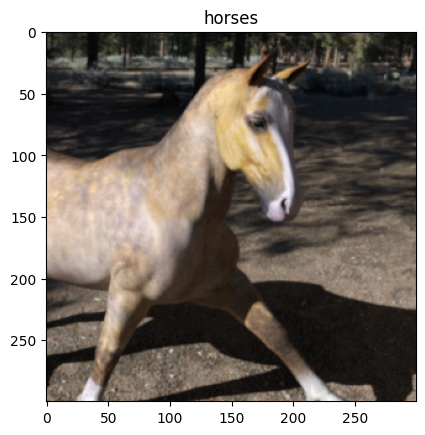

In [88]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

# Use Keras preprocessing layers

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [90]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

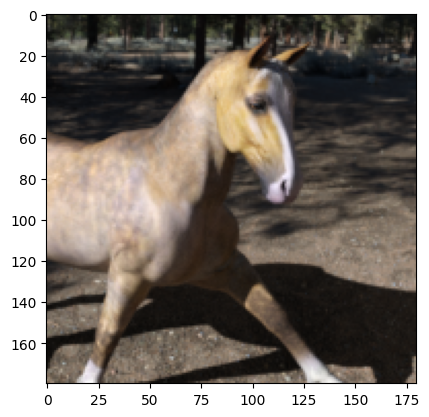

In [91]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

Here the pixels range change to [0-1] range

In [92]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.013071876 0.99651426


#Data Augmentation

We use the Keras preprocessing layers for data augmentation as well, such as tf.keras.layers.RandomFlip and tf.keras.layers.RandomRotation

In [93]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [94]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

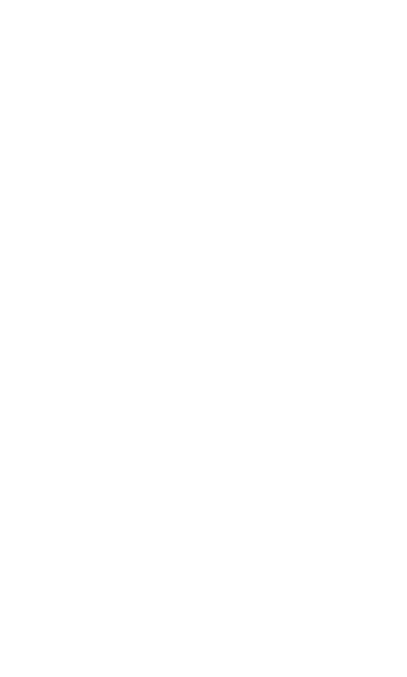

In [95]:
plt.figure(figsize=(5, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [96]:
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model.
])

In [97]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

# Apply the preprocessing layers to the datasets

In [98]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [99]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

#Train a Model

In [100]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [101]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [102]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
26/26 [==============================] - 43s 1s/step - loss: 0.8218 - accuracy: 0.6107 - val_loss: 0.5023 - val_accuracy: 0.8725
Epoch 2/5
26/26 [==============================] - 35s 1s/step - loss: 0.4747 - accuracy: 0.7822 - val_loss: 0.3914 - val_accuracy: 0.8725
Epoch 3/5
26/26 [==============================] - 34s 1s/step - loss: 0.3867 - accuracy: 0.8552 - val_loss: 0.3616 - val_accuracy: 0.8627
Epoch 4/5
26/26 [==============================] - 36s 1s/step - loss: 0.3185 - accuracy: 0.8747 - val_loss: 0.3193 - val_accuracy: 0.8725
Epoch 5/5
26/26 [==============================] - 36s 1s/step - loss: 0.2989 - accuracy: 0.8820 - val_loss: 0.3499 - val_accuracy: 0.8137


In [105]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

4/4 [==============================] - 1s 234ms/step - loss: 0.3311 - accuracy: 0.8447
Accuracy 0.844660222530365


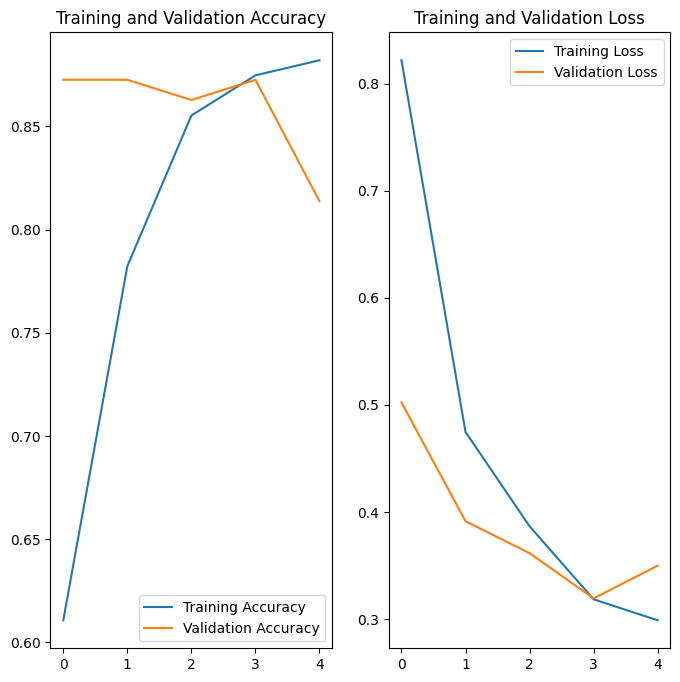

In [106]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 85% accuracy on the validation set.

In [109]:
batch_size = 32
img_height = 180
img_width = 180

In [110]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

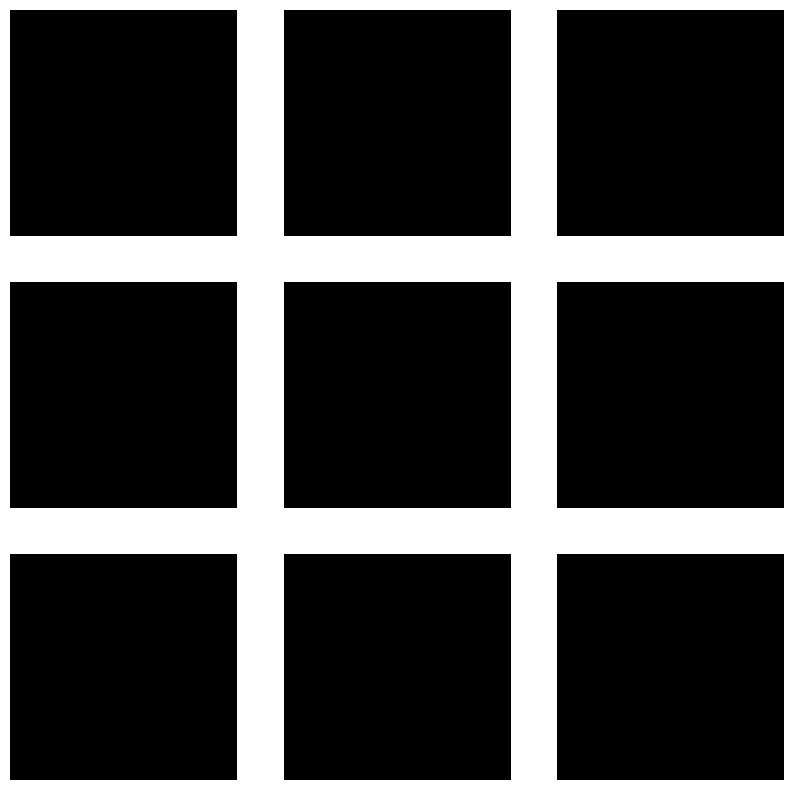

In [111]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#DropOut

In [114]:
model = tf.keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [115]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [116]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

In [117]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)



Epoch 1/15
26/26 [==============================] - 44s 2s/step - loss: 0.6929 - accuracy: 0.5268 - val_loss: 0.7089 - val_accuracy: 0.3922
Epoch 2/15
26/26 [==============================] - 39s 1s/step - loss: 0.6916 - accuracy: 0.5328 - val_loss: 0.6982 - val_accuracy: 0.3922
Epoch 3/15
26/26 [==============================] - 38s 1s/step - loss: 0.6922 - accuracy: 0.5328 - val_loss: 0.7007 - val_accuracy: 0.3922
Epoch 4/15
26/26 [==============================] - 39s 1s/step - loss: 0.6916 - accuracy: 0.5328 - val_loss: 0.7043 - val_accuracy: 0.3922
Epoch 5/15
26/26 [==============================] - 40s 2s/step - loss: 0.6916 - accuracy: 0.5328 - val_loss: 0.7087 - val_accuracy: 0.3922
Epoch 6/15
26/26 [==============================] - 38s 1s/step - loss: 0.6912 - accuracy: 0.5328 - val_loss: 0.7052 - val_accuracy: 0.3922
Epoch 7/15
26/26 [==============================] - 39s 1s/step - loss: 0.6917 - accuracy: 0.5328 - val_loss: 0.7037 - val_accuracy: 0.3922
Epoch 8/15
26/26 [==

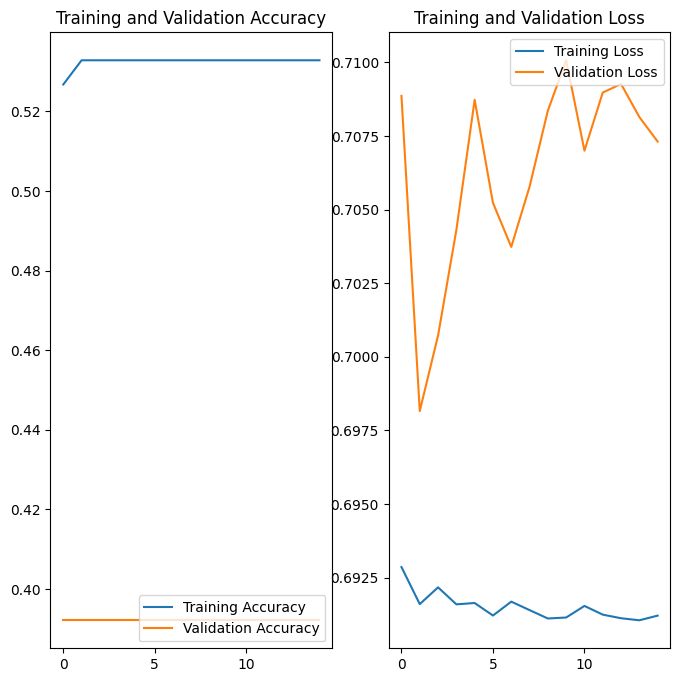

In [118]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Custom Data Augmentation

In [28]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [29]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

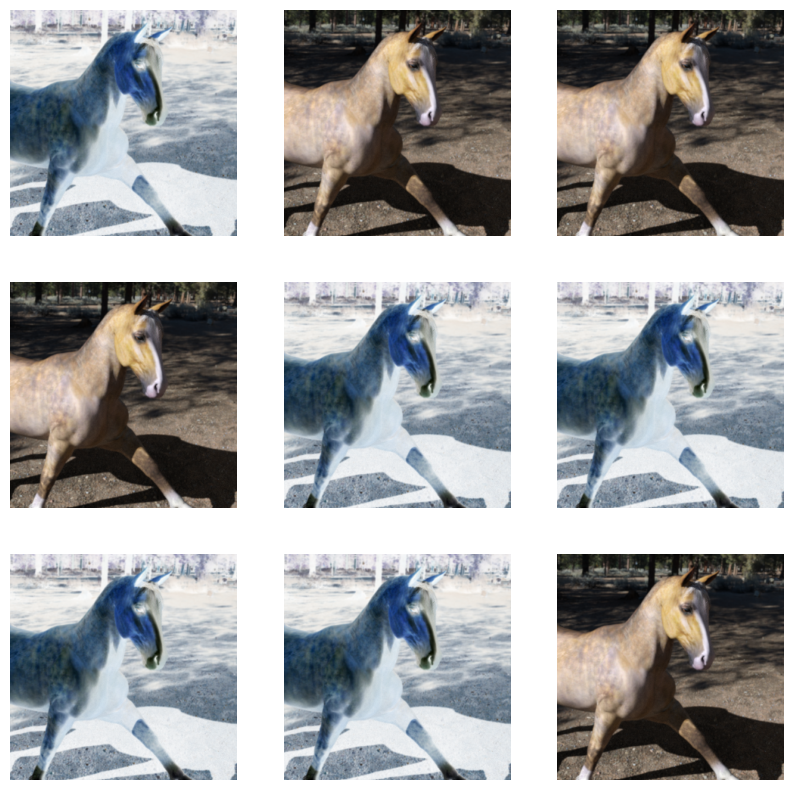

In [30]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

In [32]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

# Using tf.image


In [40]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'horses_or_humans',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

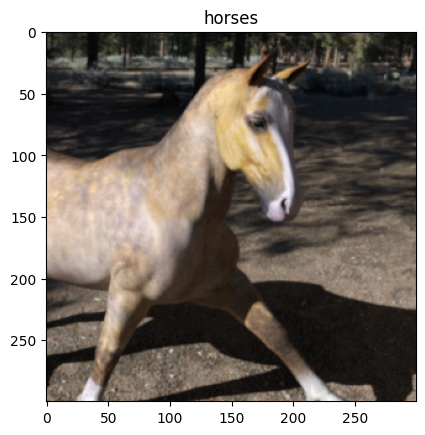

In [46]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [42]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

# Data augmentation

# Flip an Image

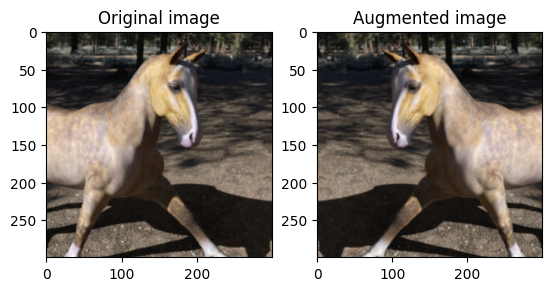

In [43]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

# Grayscale an image

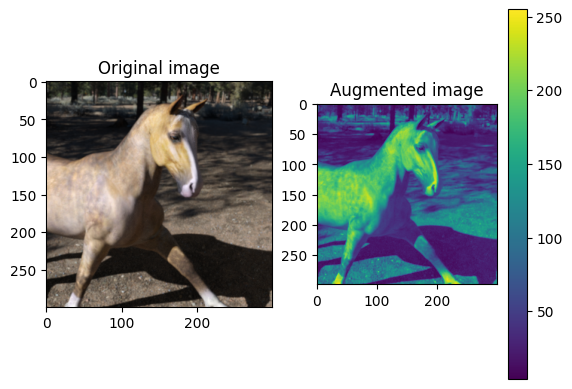

In [44]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

# Saturate an image

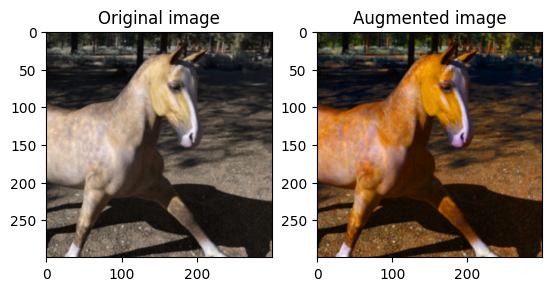

In [47]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

# Change image brightness

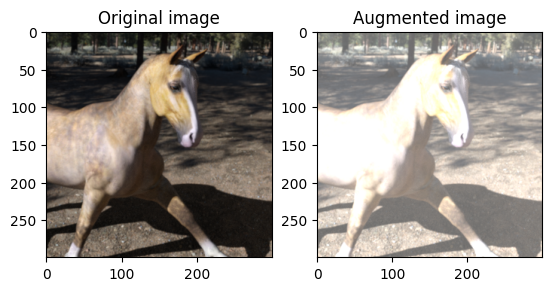

In [48]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

# Center crop an image

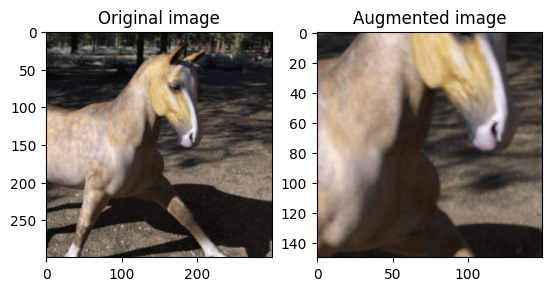

In [49]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

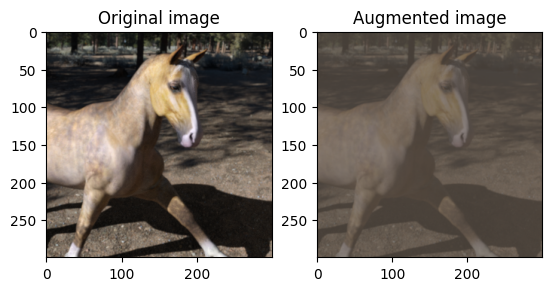

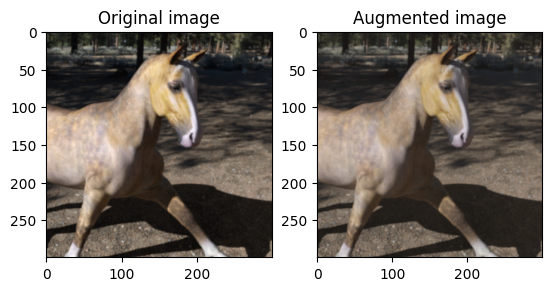

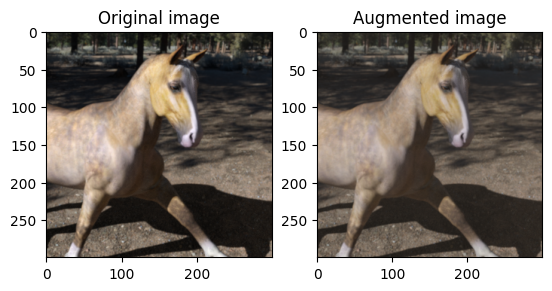

In [50]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_contrast = tf.image.stateless_random_contrast(
      image, lower=0.1, upper=0.9, seed=seed)
  visualize(image, stateless_random_contrast)

# NLP Augmentation

In [121]:
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 KB 7.5 MB/s eta 0:00:00


In [122]:
import nlpaug
nlpaug.__version__

'1.1.11'

In [123]:
import nlpaug.augmenter.audio as naa

from nlpaug.util.audio.visualizer import AudioVisualizer

In [140]:
import librosa
import librosa.display as librosa_display
import matplotlib.pyplot as plt
from nlpaug.util.audio.loader import AudioLoader
from nlpaug.util.audio.visualizer import AudioVisualizer

file_path = 'Yamaha-V50-Rock-Beat-120bpm.wav'
file_path = '/content/Yamaha-V50-Rock-Beat-120bpm.wav'
data, sr = librosa.load(file_path)

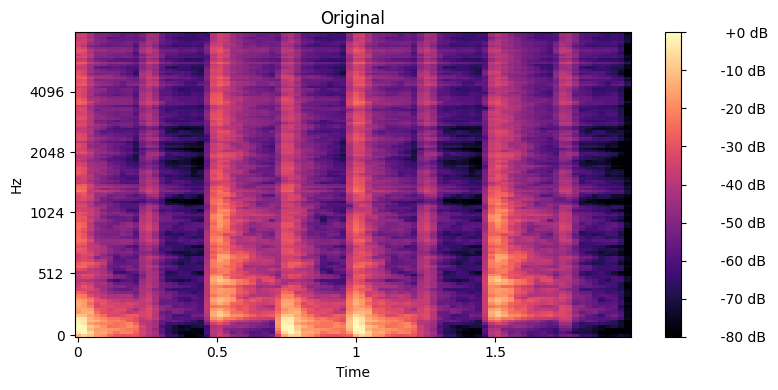

In [141]:
data = AudioLoader.load_mel_spectrogram(file_path, n_mels=128)
AudioVisualizer.spectrogram('Original', data)

In [142]:
import nlpaug.augmenter.spectrogram as nas
import nlpaug.flow as naf

# Frequency Masking

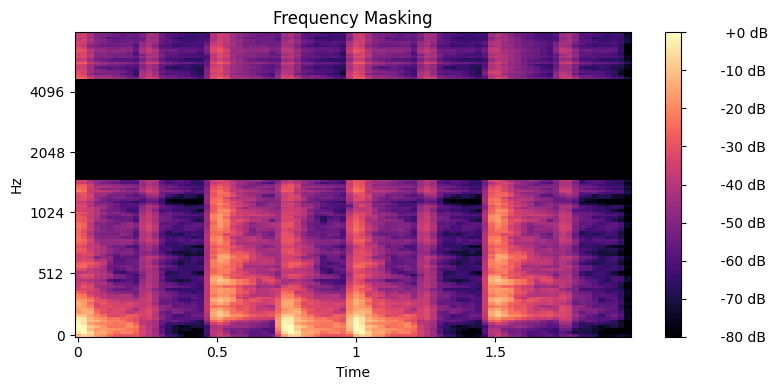

In [143]:
aug = nas.FrequencyMaskingAug(zone=(0, 1))

aug_data = aug.substitute(data)
AudioVisualizer.spectrogram('Frequency Masking', aug_data)

# Time Masking

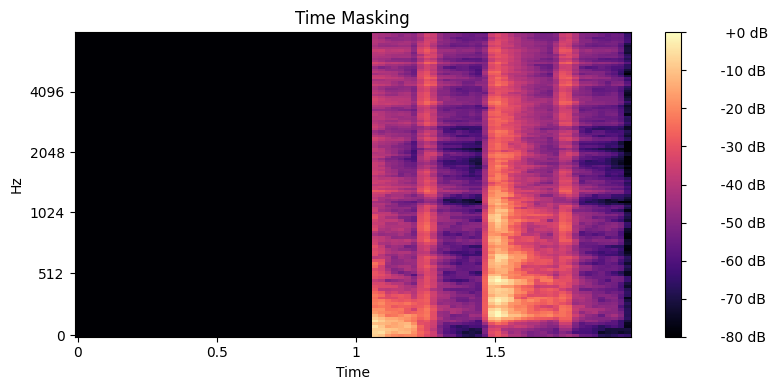

In [144]:
aug = nas.TimeMaskingAug(zone=(0, 1))

aug_data = aug.substitute(data)
AudioVisualizer.spectrogram('Time Masking', aug_data)

#Loudness

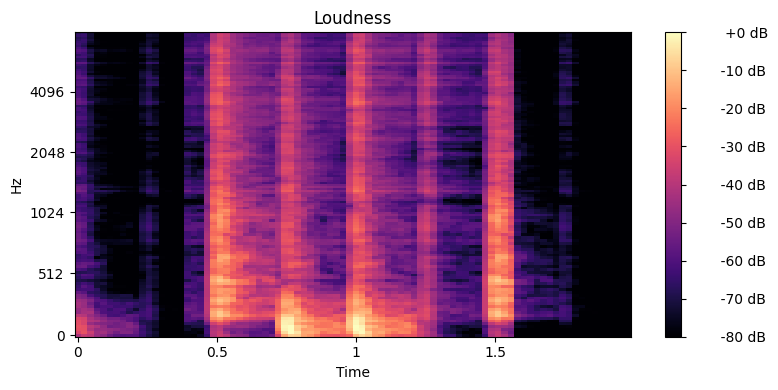

In [145]:
aug = nas.LoudnessAug()

aug_data = aug.substitute(data)
AudioVisualizer.spectrogram('Loudness', aug_data)

# Text Augmentation

In [162]:
import os
os.environ["MODEL_DIR"] = './'

In [163]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

In [164]:
text = 'The quick brown fox jumps over the lazy dog .'
print(text)

The quick brown fox jumps over the lazy dog .


In [165]:
aug = nac.OcrAug()
augmented_texts = aug.augment(text, n=3)
print("Original:")
print(text)
print("Augmented Texts:")
print(augmented_texts)

Original:
The quick brown fox jumps over the lazy dog .
Augmented Texts:
['The quick brown fux jomp8 uvek the lazy dog.', 'The quick brown fox jumps uvek the lazy du9.', 'The quick brown f0x jomp8 uvek the lazy dog.']


In [166]:
aug = nac.KeyboardAug()
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:
The quick brown fox jumps over the lazy dog .
Augmented Text:
['The q t8ck brown fox jumps ofe3 the ,aSy dog.']


In [167]:
aug = nac.RandomCharAug(action="insert")
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:
The quick brown fox jumps over the lazy dog .
Augmented Text:
['The lq*uick brown fox Dj_umps over the lyaszy dog.']


In [168]:
aug = nac.RandomCharAug(action="substitute")
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:
The quick brown fox jumps over the lazy dog .
Augmented Text:
['The quick b%owl fox jumI0 over the la@S dog.']


In [169]:
aug = nac.RandomCharAug(action="swap")
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:
The quick brown fox jumps over the lazy dog .
Augmented Text:
['The quick brown fox jmusp over the alyz dog.']


In [170]:
aug = nac.RandomCharAug(action="delete")
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:
The quick brown fox jumps over the lazy dog .
Augmented Text:
['The ick own fox ump over the lazy dog.']


# Word Augmenter

In [171]:
aug = naw.SpellingAug()
augmented_texts = aug.augment(text, n=3)
print("Original:")
print(text)
print("Augmented Texts:")
print(augmented_texts)

Original:
The quick brown fox jumps over the lazy dog .
Augmented Texts:
['tThe quick brown fox jumps overt thay lazy dog.', 'The quick Browm fox jumps over thy grazy dog.', 'The quick brown fox jumps other the laizy doga.']


In [172]:
aug = naw.SpellingAug()
augmented_texts = aug.augment(text, n=3)
print("Original:")
print(text)
print("Augmented Texts:")
print(augmented_texts)

Original:
The quick brown fox jumps over the lazy dog .
Augmented Texts:
['The qchick rown fox jumps over the lazing dog.', 'tThe quick brown fox jumps overt the lazy dadg.', 'The quick brouwn fox jumps other the lszy dog.']
